# Monte Carlo simulation of Next-Nearest-Neighbour (nnn) Ising Model

In [14]:
from numpy import *
import matplotlib.pyplot as plt
from random import *

In [642]:
def Energy_all_neighbours(spins, i, j, L):
    S = spins[i,j]
    neighbours = spins[(i+1)%L, j] + spins[(i-1)%L, j] + spins[i, (j+1)%L] + spins[i, (j-1)%L]
    nn_neighbours = (spins[(i+1)%L, (j+1)%L] + spins[(i+1)%L, (j-1)%L] + spins[(i-1)%L, (j+1)%L] 
                     + spins[(i-1)%L, (j-1)%L])
    e_ij = - S * (neighbours + nn_neighbours)
    return e_ij

In [643]:
# define energy function
def Energy(spins, L):
    E = 0.0
    for i in range(len(spins)):
        for j in range(len(spins)):
            e_ij = Energy_all_neighbours(spins, i, j, L)
            E += e_ij
    return E/2. # to avoid double counting

In [644]:
# initial temperature
def Initialize(L, spin = 2):
    """
    If spin == 2, fill with random array
    """
    #args is either 1 or -1
    spins = zeros((L, L), dtype = int)
    
    if spin == 2:
        for i in range(L):
            for j in range(L):
                spins[i,j] = choice([-1, 1])
    elif (spin == -1 or spin == 1):
        for i in range(L):
            for j in range(L):
                spins[i,j] = spin
                
    else:
        print("Spin must be -1 or 1")
        from sys import exit
        exit()
                
    return spins

In [645]:
def deltaU(spins, i, j, L):
    e_ij = Energy_all_neighbours(spins, i, j, L)
    Ediff = -2 * e_ij
    return Ediff

In [490]:
# this is the workhorse
# can modularize to return energy as well
def McMove(spins, L, T):
    E = Energy(spins, L)
    N = L*L
    for k in range(N):
        itest = int(random()*L)
        jtest = int(random()*L)
        (i,j) = (itest,jtest)
        S = spins[i,j]
        Ediff = deltaU(spins, i, j, L)
        
        # if del_E < 0, we flip. If not, pick a 0 < random() < 1 and it flips if prob > random()
        prob = exp(-Ediff/T) 
        if prob > random():
            spins[i,j] = -S
            # adjust energy to reflect flip
            E += Ediff
    return spins

In [491]:
# this is the main to make a "flipbook"
def ising_main_flipbook(MCs, L, T, state = 2):
    # set up spins
    spins = Initialize(L, state)

    # run it
    all_spins = zeros((L,L,MCs), dtype = int)
    for k in range(MCs):
        # record last state
        all_spins[:,:,k] = spins
        # move it forward
        spins = McMove(spins, L, T) 
    return all_spins

In [664]:
# this is the main to only return an array corresponding to the last time step
def ising_main(MCs, L, T, state = 2):
    # set up spins
    spins = Initialize(L, state)

    # run it
    for k in range(MCs):
        spins = McMove(spins, L, T)
    return spins

In [493]:
# set a few params
MCs = 300 # number of timesteps
L = 60 #sidelength of the NxN grid
T = 1.0

In [497]:
# run it
all_spins = ising_main_flipbook(MCs, L, T)

In [498]:
# plot some of the results

# set up time checks
checks = 5
timechecks = geomspace(1, MCs, num = checks)
timechecks = timechecks.astype(int)

# few adjustments
timechecks[0] = 0
timechecks[-1] = timechecks[-1] - 1

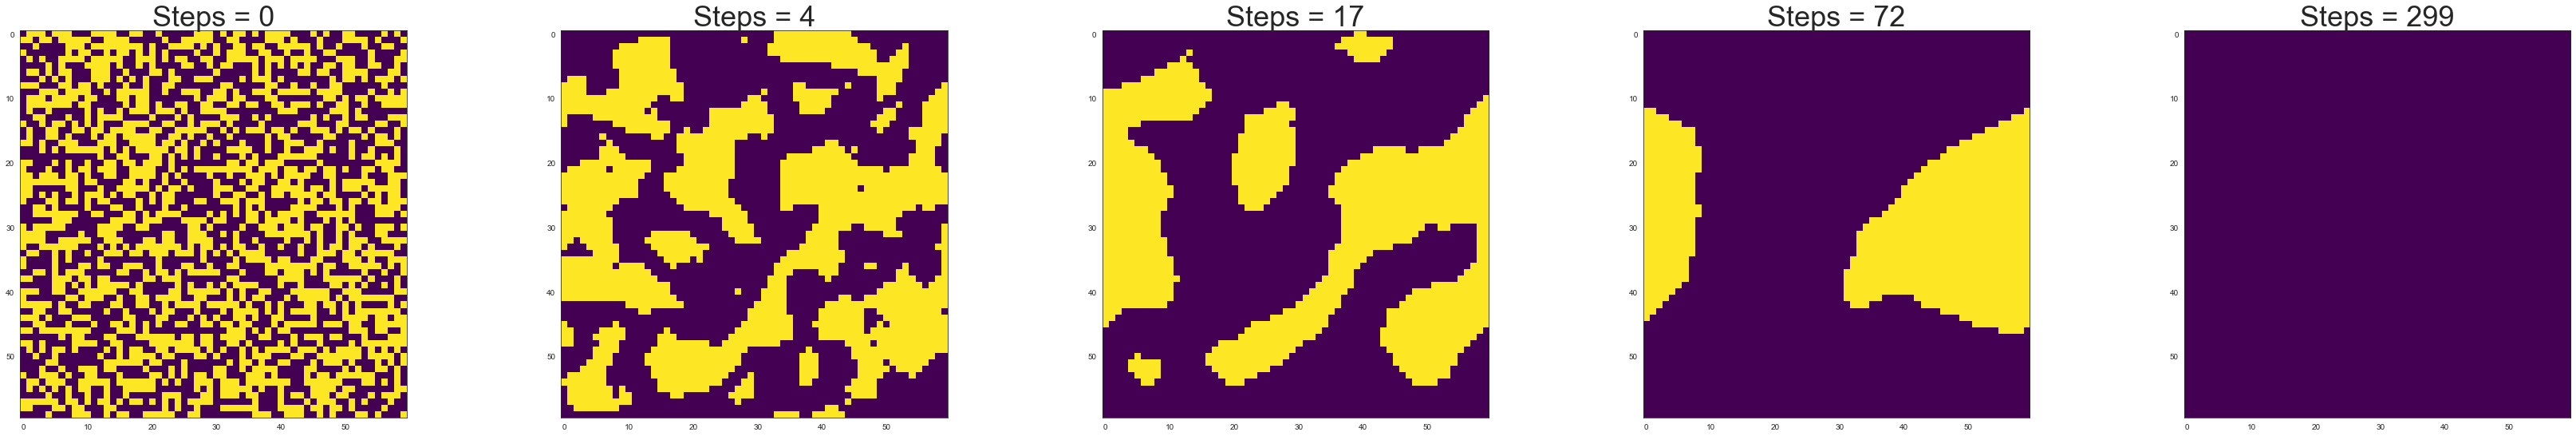

In [499]:
# plot the results
# since T = 1.0, they should be magnetized after 300 steps
fig, axs = plt.subplots(ncols = checks, figsize = (16,16))
plt.subplots_adjust(left = 0.125, right = 2.9, bottom = 0.1, top = 2.9, wspace = 0.4, hspace = 0.2)
for i,ax in enumerate(axs):
    now = timechecks[i]
    ax.set_title("Steps = {}".format(now), fontsize = 36)
    ax.imshow(all_spins[:,:,now], cmap = 'viridis')
    

In [525]:
# now we want to determine the various params
# Tc
# m 
# e
# Cv

# we will run the MC ising 100 times on each

# $T_c$

In [503]:
# recall that Tc ~ 2 * Tc(nearest neighbours) ~ 2 * 2.6...
# 2 since we have J^tilda = J + Jnnn = 2J
# we will try to estimate this with our MC program
theoretical_Tc = 2 * 2.27

In [666]:
# set up temperature linspace
# T is in units of J/k
temps = linspace(0.5, 10, num = 100)

In [667]:
# loop over all temps
L_tc = 50 # enough to aleviate boundary effect weirdness
MCS = 300 # enough to counter initial state bias

# this 3d-array will contain the final configuration (2d) for a given T (+1d)
t_spins = zeros((L_tc,L_tc,len(temps)), dtype = int)
for k,temp in enumerate(temps):
    t_spins[:,:,k] = ising_main(MCS, L_tc, temp)

In [668]:
# plot the results
checks2 = 10
indexchecks = linspace(0, len(temps), num = checks2)# endpoint = False)
indexchecks = indexchecks.astype(int)
indexchecks[-1] = indexchecks[-1] - 1

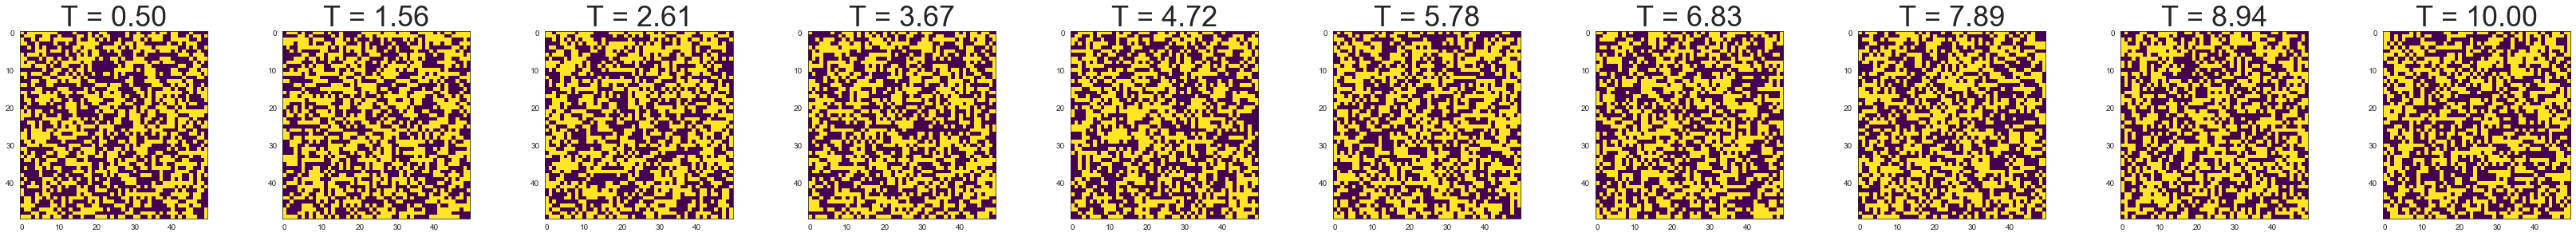

In [669]:
fig, axs = plt.subplots(ncols = checks2, figsize = (16,16))
plt.subplots_adjust(left = 0.125, right = 2.9, bottom = 0.1, top = 2.9, wspace = 0.4, hspace = 0.2)
for i,ax in enumerate(axs):
    now = indexchecks[i]
    tempnow = temps[now]
    ax.set_title("T = {:3.2f}".format(tempnow), fontsize = 36)
    ax.imshow(t_spins[:,:,now], cmap = 'viridis')
    

We see that $T_c$ occurs after $T = 4.72$.

In [384]:
# examine the range from T = 4 to 5
checks3 = 5
low_idx = abs(temps - 5).argmin()
up_idx = abs(temps - 5.5).argmin()
indexchecks3 = linspace(low_idx, up_idx, num = checks3)
indexchecks3 = indexchecks3.astype(int)

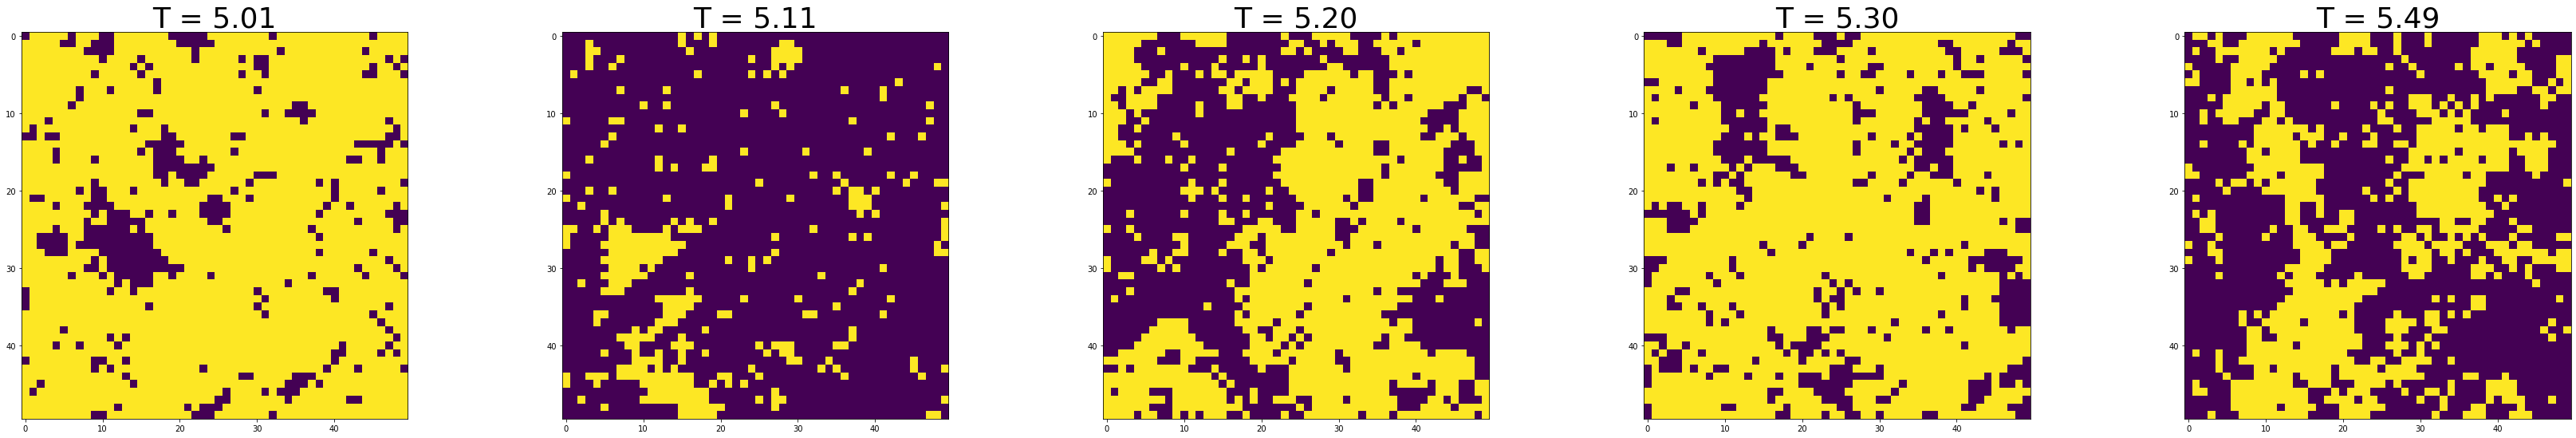

In [385]:
fig, axs = plt.subplots(ncols = checks3, figsize = (16,16))
plt.subplots_adjust(left = 0.125, right = 2.9, bottom = 0.1, top = 2.9, wspace = 0.4, hspace = 0.2)
for i,ax in enumerate(axs):
    now = indexchecks3[i]
    tempnow = temps[now]
    ax.set_title("T = {:3.2f}".format(tempnow), fontsize = 36)
    ax.imshow(t_spins[:,:,now], cmap = 'viridis')

The critical temperature corresponds to the temperature at which big clusters stop forming, and we see a more disordered (less magnetized) configuration. We see that the critical temperature occurs somewhere near $T_c = 5.2$ in units of $\frac{J}{k_b}$.

In [392]:
Tc = 5.2

# Calculation of various other values

For this, we need our array of spins to include:
- 2d grid representing our spins ($\pm 1$)
- additional axis corresponding to MC time (number of steps)
- final axis corresponding to temperature

We also need to alter our `ising_main_flipbook` to return energies, as we will need this later.

In [555]:
# we can modify slightly our McMove above to let us return the microstate's energy, E
# once we have this, we simply divide by the number of spins to get the energy per spin, e
# we could have done this right off the bat, but chose to focus on only spins for conciseness
def E_McMove(spins, L, T, cases, retene = False):
    E = Energy(spins, L)
    N = L*L
    for k in range(N):
        itest = int(random()*L)
        jtest = int(random()*L)
        (i,j) = (itest,jtest)
        S = spins[i,j]
        Ediff = deltaU(spins, i, j, L)
        
        # if del_E < 0, we flip. If not, pick a 0 < random() < 1 and it flips if prob > random()
        
        # prob > 1 so always flip
        if Ediff <= 0:
            spins[i,j] = -S
            # adjust energy to reflect flip
            E += Ediff
        
        # otherwise get the prob from cases
        else:
            idx = int((16 - Ediff)/4)
            prob = cases[idx]
            #prob = exp(-Ediff/T)
            if prob > random():
                spins[i,j] = -S
                # adjust energy to reflect flip
                E += Ediff
            
    if retene == True:
        return spins, E
    else:
        return spins

In [653]:
def E_ising_main(MCs, L, T, state = 2):
    """
    takes in steps, gridsize, temperature and initial state
    and advances the system by {steps}
    
    returns: all_spins: (L,L,MCs) array containing the progression of system
             ene: (MCs) array containing progression of energy
    """
    # set up spins
    spins = Initialize(L, state)
    ene = zeros((MCs), dtype = float)
    
    # set up cases
    possible_ediffs = asarray([16, 12, 8, 4])
    cases = exp(-(possible_ediffs)/T)

    # run it
    for k in range(MCs):
        # record last state
        # move it forward
        spins, ene[k] = E_McMove(spins, L, T, cases, retene = True)
    return spins, ene

In [556]:
# this is the main to make a "flipbook"
def E_ising_main_flipbook(MCs, L, T, state = 2):
    """
    takes in steps, gridsize, temperature and initial state
    and advances the system by {steps}
    
    returns: all_spins: (L,L,MCs) array containing the progression of system
             ene: (MCs) array containing progression of energy
    """
    # set up spins
    spins = Initialize(L, state)
    ene = zeros((MCs), dtype = float)
    
    # set up cases
    possible_ediffs = asarray([16, 12, 8, 4])
    cases = exp(-(possible_ediffs)/T)

    # run it
    all_spins = zeros((L,L,MCs), dtype = int)
    for k in range(MCs):
        # record last state
        all_spins[:,:,k] = spins
        # move it forward
        spins, ene[k] = E_McMove(spins, L, T, cases, retene = True)
    return all_spins, ene

# $m(T)$

Recall that $m \equiv \bar{S}$, that is the average spin.

Let's make our big array with all the information we'll need (state of system at each MC step and each Temperature).

In [561]:
L_m = 80
MCs_m = 500

# since we have to average over MC time, make 4d array
# the last axis will have the indexes corresponding to the temp
total_spins = zeros((L_m, L_m, MCs_m, len(temps)), dtype = int)
energies = zeros((MCs_m, len(temps)), dtype = float)

# fill it up
for k,temp in enumerate(temps):
    total_spins[:,:,:,k] , energies[:,k] = E_ising_main_flipbook(MCs_m, L_m, temp)

In [562]:
# to get m, we average over MC time and over the grid
m_avg_over_grid = average(total_spins, axis = (0,1))

# we should now have a (MCs, temps) array
m_avg_over_grid.shape

(500, 100)

In [563]:
# set up m space
m_T = zeros(temps.shape, dtype = float)

# fill it up by averaging over steps for a given T
for i in range(len(temps)):
    # average over MCs
    m_T[i] = average(m_avg_over_grid[:,i], axis = 0)

In [564]:
import seaborn as sns
sns.set_style("white")

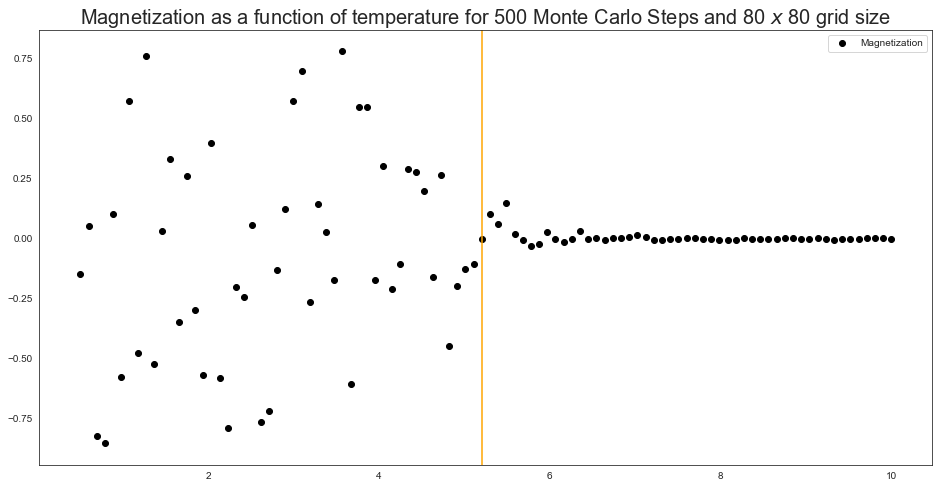

In [565]:
# plot the result
fig = plt.figure(figsize = (16, 8))
plt.title("Magnetization as a function of temperature for {0} Monte Carlo Steps and {1} $x$ {1} grid size ".
          format(MCs_m, L_m, L_m), fontsize = 20)
plt.scatter(temps, m_T, c = 'k', label = "Magnetization")
plt.axvline(x = Tc, c = 'orange')
plt.legend()
plt.show()

This agrees with the exponents found with the 

# $e(T)$

In [572]:
def energy_per_spin(energy, temperature):
    """
    Takes in energy array and temperature array that it is based on
    Returns 1d energy per spin array with dimension of temperature array
    """
    # we will  calculate E
    # we need to average e over the time steps
    E_T = zeros(temperature.shape, dtype = float)

    # fill it up by averaging over steps for a given T
    for i in range(len(temperature)):
        # average over MCs
        E_T[i] = average(energy[:,i], axis = 0)

    # finally, divide by the total number of spins
    N_spins = L_m ** 2
    e_T = E_T / N_spins
    return e_T

In [573]:
# calculate the energy per spin
e_T = energy_per_spin(energies, temps)

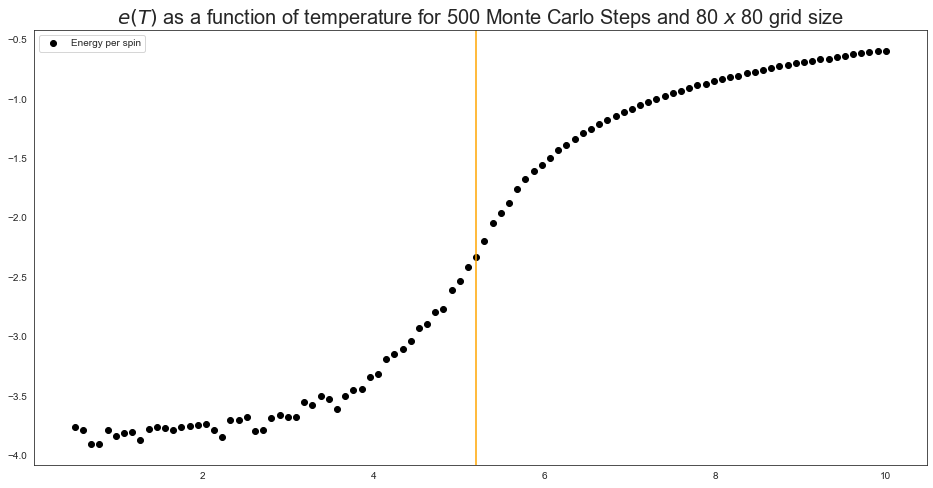

In [574]:
# plot the energies vs the temperature
fig = plt.figure(figsize = (16, 8))
plt.title("$e(T)$ as a function of temperature for {0} Monte Carlo Steps and {1} $x$ {1} grid size ".
          format(MCs_m, L_m, L_m), fontsize = 20)
plt.scatter(temps, e_T, c = 'k', label = "Energy per spin")
plt.axvline(x = Tc, c = 'orange')
plt.legend()
plt.show()

The splitting at low temperatures is caused by the spontaneous symmetry breaking, where we go into a more or less comppletely $S = 1$ or $S= -1$ state spontaneously, thus causinng the energy to choose between ~ -3.6 and ~ -4.0.

# $C_V$

In [575]:
# to find Cv, take the derivative of e wrt T
delta_T = abs(temps[1] - temps[0])
Cv = gradient(e_T, delta_T)

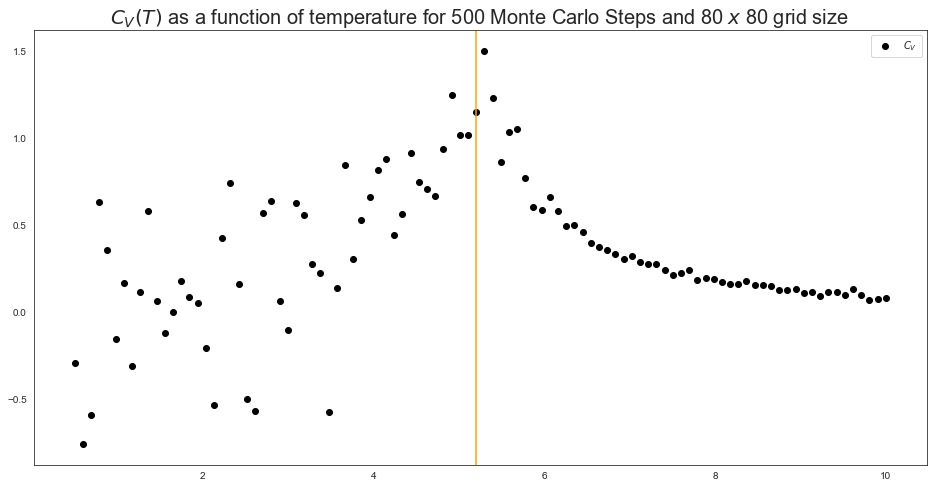

In [576]:
# plot it vs temperatures
fig = plt.figure(figsize = (16, 8))
plt.title("$C_V(T)$ as a function of temperature for {0} Monte Carlo Steps and {1} $x$ {1} grid size ".
          format(MCs_m, L_m, L_m), fontsize = 20)
plt.scatter(temps, Cv, c = 'k', label = "$C_V$")
plt.axvline(x = Tc, c = 'orange')
plt.legend()
plt.show()

# $T_c (L)$

We now want to plot $T_c$ as a function of $L$, the grid size.

In [640]:
def critical_temperature(eps, temperature):
    """
    Takes in energy per spin and temperature arrays
    Returns scalar critical temperature
    Uses the maximization of Cv as representation of critical temperature
    """
    delta_t = abs(temperature[1] - temperature[0])
    heat_cap = gradient(eps, delta_t)
    
    # to ignore early transients, chop off first 1/5th
    one_fifth_length = int(len(heat_cap)/5)
    heat_cap_fixed = heat_cap[one_fifth_length:]
    
    crit_idx = argmax(heat_cap_fixed)
    crit_temp = temperature[crit_idx]
    
    return crit_temp